In [1]:
import os
from pathlib import Path
path = Path(os.getcwd())
os.chdir(path.parent.absolute())

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pandas_ta as ta
import vectorbt as vbt
import mt4_hst
from stock_env.feature.feature_extractor import TrendFeatures

In [2]:
cheight, cwidth = 500, 1000 # Adjust as needed for Chart Height and Width
vbt.settings.set_theme("seaborn") # Options: "light" (Default), "dark" (my fav), "seaborn"

# Must be set
vbt.settings.portfolio["freq"] = "1D" # Daily

# Predefine vectorbt Portfolio settings
vbt.settings.portfolio["init_cash"] = 1e4
vbt.settings.portfolio["fees"] = 0.0015 # 0.25%
vbt.settings.portfolio["slippage"] = 0.0015 # 0.25%
vbt.settings.portfolio["size"] = 100
# vbt.settings.portfolio["accumulate"] = False
vbt.settings.portfolio["allow_partial"] = False

In [3]:
ticker = 'FPT'
benchmark = 'VNINDEX'
# df = mt4_hst.read_hst("stock_env/datasets/FPT1440.hst")

benchmark = mt4_hst.read_hst("../stock_datasets/" + benchmark + "1440.hst")
benchmark = benchmark[['time', 'close']].rename(columns={'close': 'benchmark'})
df = mt4_hst.read_hst("../stock_datasets/" + ticker + "1440.hst")
df = df.merge(benchmark, how='inner', on='time')
df = TrendFeatures().preprocess(df, asbool=True, return_all=True)
df.index = df['time']
# df.to_csv('temp/signal/' + ticker + '.csv', index=False)

# Backtest

In [4]:
from stock_env.utils import create_performance

# Asset Portfolio from Trade Signals
assetpf_signals = vbt.Portfolio.from_signals(
    df.close,
    entries=df.TS_Entries,
    exits=df.TS_Exits,
)
assetpf_signals.stats(settings=dict(benchmark_rets=df.benchmark.pct_change()))

Start                         2007-03-01 00:00:00
End                           2022-08-10 00:00:00
Period                         3850 days 00:00:00
Start Value                               10000.0
End Value                             14469.03074
Total Return [%]                        44.690307
Benchmark Return [%]                    11.804257
Max Gross Exposure [%]                  61.902516
Total Fees Paid                        200.058239
Max Drawdown [%]                        10.232994
Max Drawdown Duration           650 days 00:00:00
Total Trades                                   30
Total Closed Trades                            30
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                 60.0
Best Trade [%]                          54.145882
Worst Trade [%]                         -8.256864
Avg Winning Trade [%]                   15.510104
Avg Losing Trade [%]                    -4.059613



    Annual return     :  2.45%
    Cumulative return :  44.69%
    Sharpe ratio      :  0.57
    Maximum Drawdown  : -10.23%
    Annual Volatility :  4.45%
    Value-At-Risk     :  nan%
    


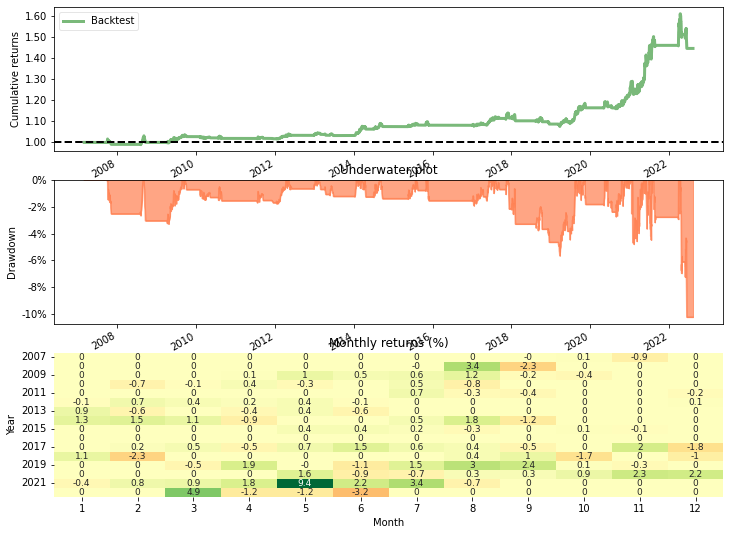

In [5]:
values = assetpf_signals.value()
values.index = df['time']
returns = values.pct_change()
create_performance(returns)

In [6]:
fig = df.close.vbt.plot(trace_kwargs=dict(name=ticker), autosize=False,width=1000,height=500)
assetpf_signals.positions.plot(close_trace_kwargs=dict(visible=False), fig=fig)

FigureWidget({
    'data': [{'name': 'FPT',
              'showlegend': True,
              'type': 'scatter',…

In [8]:
values.vbt.drawdowns.plot(top_n=3)

FigureWidget({
    'data': [{'line': {'color': 'rgb(76,114,176)'},
              'showlegend': False,
        …